In [1]:
import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/ralfbanisch/Documents/git/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler #as sampler
import model #as model
# import diffusionmap as dm
# import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
# from openmmtools.constants import kB

from pydiffmap import diffusion_map as dmpy
import helpers
import model



Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)


In [4]:


############################
# target temperature
T=500.0

T_target=300.0


dataName='TemporaryData_T500K'
folderName='/Users/ralfbanisch/Documents/git/DFM/'
methodName='std_500'

modelName='Dimer'

modnr = 100

colective_variable = helpers.compute_radius
cv_name = 'Radius'

# results from this code will be saved here:
simulationFolder='/Users/ralfbanisch/Documents/git/DFM/TemporaryFigures/'+modelName+'/'+methodName

# load results from reference simulation already postprocessed
addReference=0
reference_folder = '/Users/ralfbanisch/Documents/git/DFM/TemporaryFigures/'+modelName+'/std_300'

### reference at 300K
# Raw:
# <Radius> = Quantity(value=1.7522397, unit=angstrom)
#
# Unbiased:
# <Radius> = Quantity(value=1.5599391188475216, unit=angstrom)
# Raw:
# <E> = Quantity(value=4.8909900846302508, unit=kilojoule/mole)
#
# Unbiased:
# <E> = Quantity(value=3.1952283576218186, unit=kilojoule/mole)
# ->3.46 :)
#t 500:
# Raw:
# <Radius> = Quantity(value=2.1970608, unit=angstrom)
#
# Unbiased:
# <Radius> = Quantity(value=1.5851064100553285, unit=angstrom)
# Raw:
# <E> = Quantity(value=8.2463439643144607, unit=kilojoule/mole)
#
# Unbiased:
# <E> = Quantity(value=3.6909848345915366, unit=kilojoule/mole)
# ############################




In [5]:
mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
# print (mdl.testsystem.positions)
# X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)





temperature =  T * unit.kelvin#300 * unit.kelvin
temperature_target =  T_target * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_raw=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')


integrator_target=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature_target, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_target=sampler.Sampler(model=mdl, integrator=integrator_target, algorithm=0, dataFileName='Data')

if methodName == 'std_300':
    smpl=smpl_target
elif(methodName == 'std_500') :
    smpl=smpl_raw





newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)


Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)
angstrom
System has 2 particle(s)
1485.75204304 K
845.566319596 K


## load data

Data length is 10000


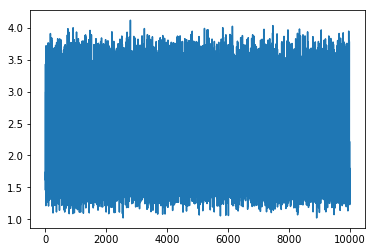

In [8]:
import glob
data_folder='/Users/ralfbanisch/Documents/git/DFM/TemporaryData_T500K/'+modelName+'/'+methodName
file_names = []
for file_name in glob.glob(data_folder + '/Traj' + '/*.h5'):
    file_names.append(file_name)

traj = md.load(file_names, mdl.testsystem.topology, stride=modnr)
traj.superpose(traj, 0)

X_FT=traj.xyz
print('Data length is '+repr(len(X_FT)))


#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

## test mdtraj superpose stuff

We already superposed when loading, so this should just work nicely...

In [9]:
Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

print(Xresh.shape)

(10000, 6)


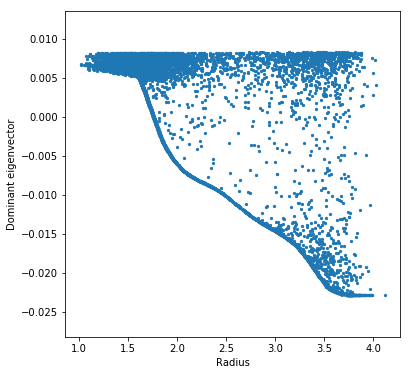

In [10]:
################ diffusion diffmaps

epsilon=10.0

mydmap = dmpy.DiffusionMap(n_evecs = 1, epsilon = epsilon, alpha = 0.5, k=500)
dmap = mydmap.fit_transform(Xresh)

P = mydmap.P
evals = mydmap.evals
evecs = mydmap.evecs

[evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
phi = np.real(evecsT.ravel())
cv=colective_variable(X_FT)

fig = plt.figure(figsize=(6,6))
plt.scatter(cv, evecs[:,0], s=5)
plt.xlabel('Radius')
plt.ylabel('Dominant eigenvector')

fig.savefig(simulationFolder+'/dominant_eigenvector.png')
plt.show()
#####

not that great....

## get target density at sampled data points

Get the target density at sampled data points
... might take a while ...
Done


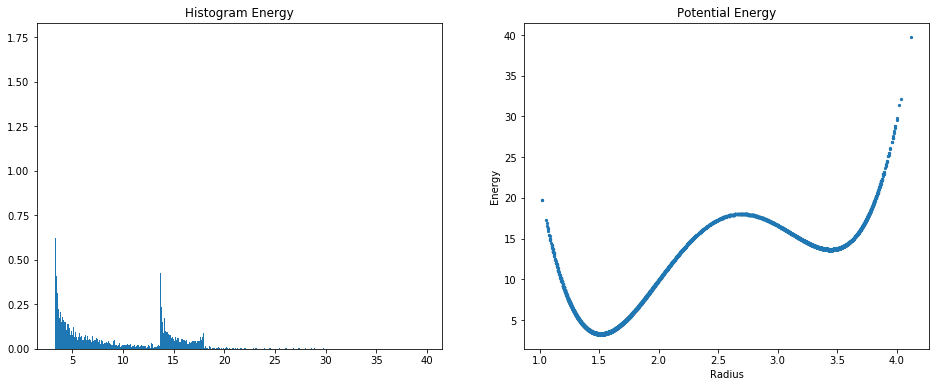

In [11]:

print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

qTargetDistribution, E = helpers.computeTargetMeasure(X_FT, smpl)


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E, 1000, normed=True)
ax.set_title('Histogram Energy')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/energy.png')

plt.show()

## we write our own rmsd kernel

In [22]:
import scipy.sparse as sps

indptr = [0]
indices = []
data = []
k = 1000
epsilon = 0.0001

for i in range(traj.n_frames):
    # compute distances to frame i
    distances = md.rmsd(traj, traj, i)
    # this performs a partial sort so that idx[:k] are the indices of the k smallest elements
    idx = np.argpartition(distances, k)
    # retrieve corresponding k smallest distances
    distances = distances[idx[:k]]
    # append to data structure
    data.extend(np.exp(-1.0/epsilon*distances**2).tolist())
    indices.extend(idx[:k].tolist())
    indptr.append(len(indices))

kernel_matrix = sps.csr_matrix((data, indices, indptr), dtype=float, shape=(traj.n_frames, traj.n_frames))

In [23]:
# this is all stolen from pydiffmap
weights_tmdmap = qTargetDistribution

alpha = 1.0
q = np.array(kernel_matrix.sum(axis=1)).ravel()
# Apply right normalization
right_norm_vec = np.power(q, -alpha)
if weights_tmdmap is not None:
    right_norm_vec *= np.sqrt(weights_tmdmap)

m = right_norm_vec.shape[0]
Dalpha = sps.spdiags(right_norm_vec, 0, m, m)
kernel_matrix = kernel_matrix * Dalpha

# Perform  row (or left) normalization
row_sum = kernel_matrix.sum(axis=1).transpose()
n = row_sum.shape[1]
Dalpha = sps.spdiags(np.power(row_sum, -1), 0, n, n)
P = Dalpha * kernel_matrix

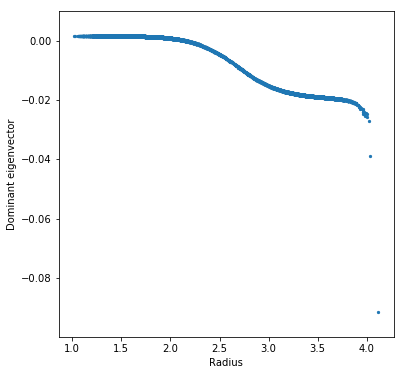

In [24]:
n_evecs = 2

evals, evecs = spsl.eigs(P, k=(n_evecs+1), which='LM')
ix = evals.argsort()[::-1][1:]
evals = np.real(evals[ix])
evecs = np.real(evecs[:, ix])
dmap = np.dot(evecs, np.diag(evals))

[evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
phi = np.real(evecsT.ravel())

fig = plt.figure(figsize=(6,6))
plt.scatter(cv, evecs[:,0], s=5)
plt.xlabel('Radius')
plt.ylabel('Dominant eigenvector')
plt.show()

that looks much better...

## old stuff

In [35]:

# estimated density by KDE
q_est = q*phi
#q_est = phi*mydmap.q
q_estNormalized = q_est/sum(q_est)

qTargetDistributionNormalized = qTargetDistribution/sum(qTargetDistribution)
print("Error on the density: "+repr(np.linalg.norm(q_estNormalized - qTargetDistributionNormalized,1)))

## compute weights

weight = qTargetDistribution/(mydmap.q)
qTargetDistributionNormalized=qTargetDistribution/np.sum(qTargetDistribution)

print('Sum weights is '+repr(np.sum(weight)))
print('mean weight is '+repr(np.mean(weight)))
print('sum weight is '+repr(np.sum(weight)))
print('max weight is '+repr(np.max(weight)))
print('min weight is '+repr(np.min(weight)))
print('Max error is '+repr(np.max(np.abs(qTargetDistributionNormalized-q_estNormalized))))
print('Mean error is '+repr(np.mean(np.abs(qTargetDistributionNormalized-q_estNormalized))))



Error on the density: 0.029219793415577684
Sum weights is 4.0015031001884029
mean weight is 0.00040015031001884029
sum weight is 4.0015031001884029
max weight is 0.0013182301088305517
min weight is 2.5971457932284505e-07
Max error is 2.2587223551687408e-05
Mean error is 2.9219793415577683e-06


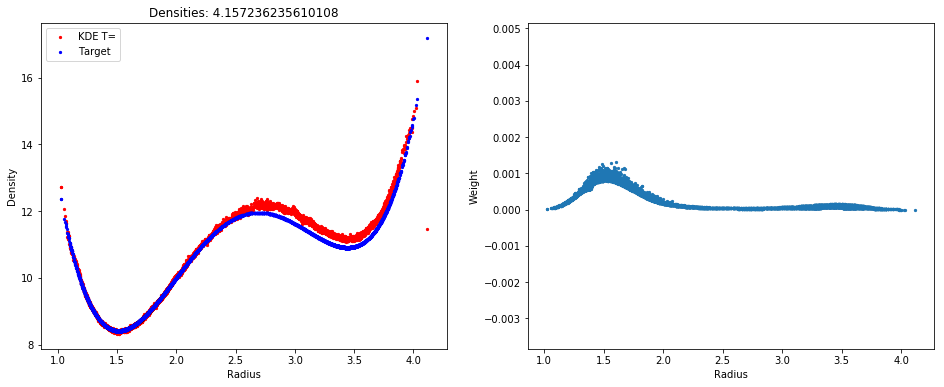

In [36]:

if addReference:
    q_estNormalized_ref = np.load(reference_folder+'/density_300K.npy')
    qTargetDistributionNormalized_ref = np.load(reference_folder+'/kde_300K.npy')
    cv_ref = np.load(reference_folder+'/cv_300K.npy')
    
else:
        np.save(reference_folder+'/density_300K.npy',  (qTargetDistributionNormalized))
        np.save(reference_folder+'/kde_300K.npy',  (q_estNormalized))
        np.save(reference_folder+'/cv_300K.npy',  cv)





### plot densities and weights


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(cv, -np.log(q_estNormalized), s=5, c='r')
ax.scatter(cv, -np.log(qTargetDistributionNormalized), s=5, c='b')
if addReference:
    ax.scatter(cv_ref, q_estNormalized_ref, s=5, c='g')
    ax.scatter(cv_ref, qTargetDistributionNormalized_ref, s=5, c='k')
    ax.legend(['KDE','Target', 'KDE_ref', 'Target ref'])
else:
    ax.legend(['KDE T=','Target'])
ax.set_xlabel('Radius')
ax.set_ylabel('Density')


ax.set_title('Densities: '+repr(smpl.kT.value_in_unit(smpl.model.energy_unit)))


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), weight  ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Weight')
#ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/KDE_weight.png')


plt.show()


In [37]:

##### compute Averages

observable=cv

meanR=np.mean(observable)
meanRunbiased=np.mean(observable*weight)/np.mean(weight)

print('Raw:')
print('<'+cv_name+'> = '+repr(meanR*smpl.model.x_unit))

print('\nUnbiased:')
print('<'+cv_name+'> = '+repr(meanRunbiased*smpl.model.x_unit))

#compute mean energy

meanE=np.mean(E)
meanEunbiased=np.mean(E*weight)/np.mean(weight)

print('Raw:')
print('<E> = '+repr(meanE*smpl.model.energy_unit))

print('\nUnbiased:')
print('<E> = '+repr(meanEunbiased*smpl.model.energy_unit))

##############


Raw:
<Radius> = Quantity(value=2.1970608, unit=angstrom)

Unbiased:
<Radius> = Quantity(value=1.688200628893807, unit=angstrom)
Raw:
<E> = Quantity(value=9.0812935886248951, unit=kilojoule/mole)

Unbiased:
<E> = Quantity(value=5.1713398741522072, unit=kilojoule/mole)


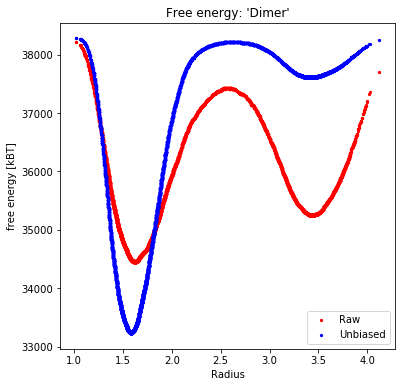

In [38]:
import imp
imp.reload(helpers)

width=0.1
cv=colective_variable(X_FT)
addReference=0

free_energy_raw=helpers.compute_free_energy(X_FT, cv, width=width, kBT=smpl.kT)
free_energy_unbiased=helpers.compute_free_energy(X_FT, cv, width=width, weights=weight, kBT=smpl.kT)

if(addReference):
    free_energy_raw_ref = np.load(reference_folder+'/free_energy.npy')
    free_energy_unbiased_ref = np.load(reference_folder+'/free_energy_unbiased.npy')
    cv_ref = np.load(reference_folder+'/cv_for_free_energy.npy')




fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(cv, free_energy_raw, s=5, c='r')
ax.scatter(cv, free_energy_unbiased, s=5, c='b')
if(addReference):
    ax.scatter(cv_ref, free_energy_raw_ref, s=5, c='g')
    ax.scatter(cv_ref, free_energy_unbiased_ref, s=5, c='k')
ax.set_xlabel(cv_name)
ax.set_ylabel('free energy [kBT]')
if(addReference):
    ax.legend(['Raw','Unbiased', 'Ref raw', 'Ref unbiased'])
else:
    ax.legend(['Raw','Unbiased'])
ax.set_title('Free energy: '+repr(modelName))

fig.savefig(simulationFolder+'/free_energy.png')

np.save(simulationFolder+'/free_energy_raw', free_energy_raw)
np.save(simulationFolder+'/free_energy_unbiased', free_energy_unbiased)
np.save(simulationFolder+'/radius_for_free_energy', cv)
plt.show()

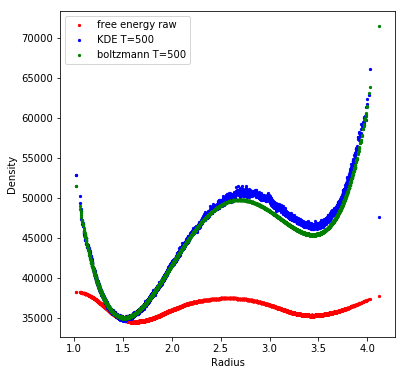

In [39]:
fig = plt.figure(figsize=(6,6))
plt.scatter(cv, free_energy_raw, s=5, c='r')
plt.scatter(cv,-T*mdl.kB_const*np.log(q_estNormalized), s=5, c='b')
plt.scatter(cv, -T*mdl.kB_const*np.log(qTargetDistributionNormalized), s=5, c='g')
plt.legend(['free energy raw','KDE T=500','boltzmann T=500'])
plt.xlabel('Radius')
plt.ylabel('Density')
plt.show()